# Keras: Time Series Anomaly Detection

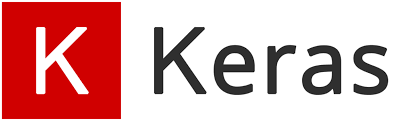  

*Image Source: [keras.io](https://www.google.com/url?sa=i&url=https%3A%2F%2Fkeras.io%2F&psig=AOvVaw0UBeWnvYZ1dnqIIIKth3rk&ust=1672688886478000&source=images&cd=vfe&ved=2ahUKEwjkrbrokaf8AhXIRMAKHa2CBgIQr4kDegUIARDBAQ)*
***

This Jupyter notebook will contain my submission for the project aspect of the assessment for the Machine Learning & Statistics module (Winter 2022).  
<br>  
The focus of this project will be time-series anomaly detection using Keras. In this notebook, I have recreated and broken down [this example code](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) from the Keras website (with some changes suggested by the lecturer in his [notebook](https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb)) creating a reconstruction convolutional autoencoder model into four sections:  
1. Data  
2. Pre-Processing  
3. Neural Network  
4. Evaluation    

Under each section, I will give an overview of what is happening in the code and what the user can expect to see, and aim to clearly explain each Keras function used.  
<br>  
Finally, I suggest some improvements that could be made to the analysis. The notebook concludes with a list of references referred to and consulted in the completing of this project.

<br>

## 1. Data
***  

The data used in this project is artificial data taken from the Numenta Anomaly Benchmark (NAB) dataset. Introduced in 2015, NAB is an open source framework comprised of labeled data files which uses a common scoring system "_to compare and evaluate different anomaly detection algorithms for detecting anomalies in streaming data_". [3]

In this section, we will gather the data & modules needed for the project, import the data into dataframes, check that the data looks OK and do an inital plot of the data so we can take a look at what we're working with.  
<br>  


In [1]:
# Numerical arrays
import numpy as np

# Spreadsheet-like Data Frames
import pandas as pd

# Neural networks
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Root of URLs
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Checking the no-anomaly URL looks OK
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# Checking the with anomaly URL looks OK
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Reading the no-anomaly data into a data frame called small noise
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Taking a look at the top 5 values in the data frame
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Using describe to check how many lines are in the data & see some basic stats
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [8]:
# Taking a look at the first value in the data frame
#df_small_noise.iloc[0]
#df_small_noise.iloc[0].values[0]
df_small_noise.iloc[0]['value']

18.3249185392

In [9]:
# Use shape method to see how many values are in the data frame
df_small_noise.shape

(4032, 1)

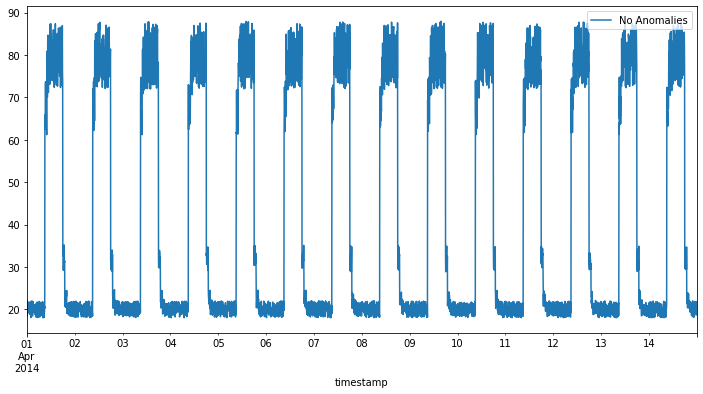

In [10]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12,6))

# Use pandas to plot the data frame
df_small_noise.plot(ax=ax);

# showing the legend - https://www.statology.org/pandas-plot-legend/
plt.legend(['No Anomalies'], loc="upper right");

In [11]:
# Reading the with anomaly data into a data frame called daily jumpsup
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [12]:
# Have a look at the top 5 values
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [13]:
# Using the describe method to see the no. of values & other basic stats of the date frame
df_daily_jumpsup.describe()

#df_daily_jumpsup.shape

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [14]:
# Checking the first value in the second data frame
df_daily_jumpsup.iloc[0]['value']

19.761251903

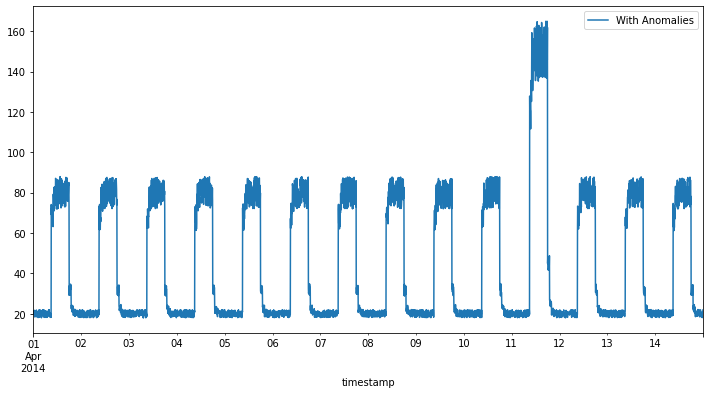

In [15]:
# Creating another subplot & setting figsize
fig, ax = plt.subplots(figsize=(12,6))

# Use pandas to plot the second data frame
df_daily_jumpsup.plot(ax=ax);

# show the legend
plt.legend(['With Anomalies'], loc="upper right");

<br>

## 2. Pre-Processing
***

In this section, we prepare the data we are going to use to train the model by doing calculations on the dataset with no anomalies using the mean and standard deviation methods. We then break the data into sequences (which we call windows) and store the data inside a value called x_train.  
<br>  

We want to normalise the data we use to train the model to make it easier for us to comprehend, and we will do this by subtracting the mean from each value in the no-anomaly dataset, and then dividing it by the standard deviation. The result will be stored in a new data frame called df_train_vals, and the data inside it will be centred around zero.  
<br>  

In the [Keras example](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) which this project is based on, the author sets the number of windows to be 288, as the dataset has values for every 5 mins for 14 days:  
- 24 * 60 / 5 = 288 timesteps per day  
- 288 * 14 = 4032 total data points  

In [16]:
# get the mean of the no-anomaly dataset & store it in var train_mean
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [17]:
# get the standard deviation of the no-anomaly dataset & store it in var train_std
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [18]:
# divide the difference between each no-anomaly value & its mean by the standard deviation
# store the result in a new data frame called df_train_vals
df_train_vals = (df_small_noise - train_mean) / train_std

In [19]:
# Take a look at the top 5 values in the new data frame
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [20]:
# take a look at the mean and standard deviation of the new data frame
df_train_vals['value'].mean(), df_train_vals['value'].std()

(-2.616541242931684e-15, 1.0000000000000018)

Note: coolconversion.com [1] tells me the mean is -0.000000000000002616541242931684 when you convert the scientific notation to a decimal number.

In [21]:
df_train_vals

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


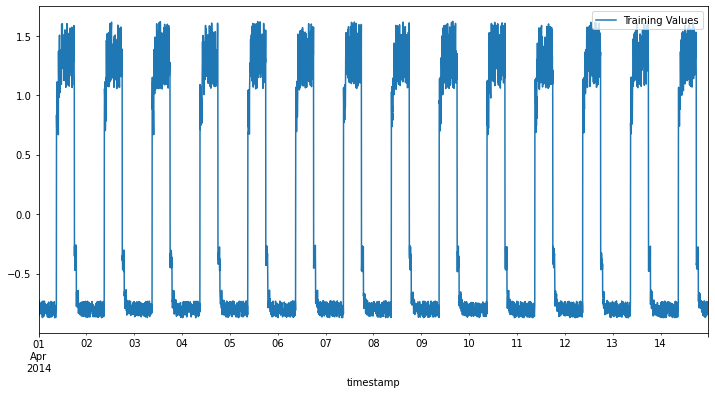

In [22]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12,6))

# Plotting the train_vals data frame with pandas
df_train_vals.plot(ax=ax);

plt.legend(['Training Values'], loc="upper right");

Compare this plot to the previous one where we plotted df_small_noise (the no-anomaly dataset). From a quick glance, the two look the same but upon investigating the values you can see that we have essentially scaled the original values down to be centred around zero, with a standard deviation of approximately 1.  
<br>  
 

In [23]:
# using shape to see how many values are in the train_vals data frame
df_train_vals.shape

(4032, 1)

In [24]:
# we need to break the train_vals into sequences or "windows" so we can look at each value
# in relation to its peers - here we determine the window size will be 288
window_size = 288

In [25]:
# defining a function to split the data into windows of size 288
def windows(vals, n=window_size):
  # creating a list L to store the windows
  L = []
  # looping through the data up to range 3745 (where the last window begins - 4032-288+1)
  for i in range(len(vals) - n + 1):
    # append each window to L
    L.append(vals[i:i+n])
  # stack method will create a 2D numpy array from L
  return np.stack(L)

In [26]:
# pass the train_vals to the windows function & store result in var x_train
x_train = windows(df_train_vals)

In [27]:
# checking value in first index of first window and last index of last window
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [28]:
# checking first and last value in df_train_vals - these should be the same as above
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [29]:
# using shape to check the # of values in x_train
# note that 3745 + 288 -1 = 4032 (the # values in train_vals)
x_train.shape

(3745, 288, 1)

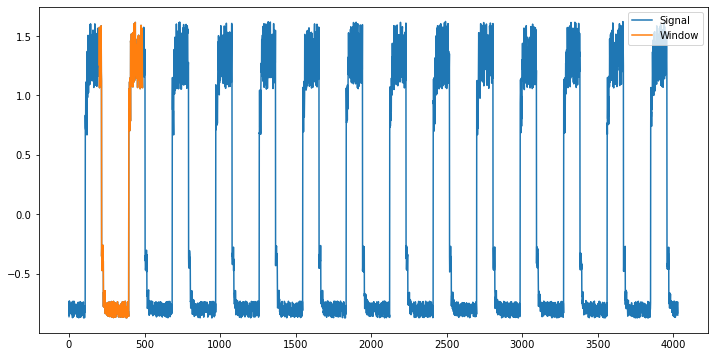

In [30]:
# set value for window number - this will be used as an index below
window_no = 200

# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# set y = the values in the train_vals data frame
y = df_train_vals['value'].values

# plot y with label signal
ax.plot(np.arange(y.shape[0]), y, label='Signal')

# set var w = window at index 200 in x_train - flatten will remove the inner arrays
w = x_train[window_no].flatten()

# plot w on top of y with label window
ax.plot(np.arange(w.shape[0]) + window_no, w, label='Window')

# show the legend, position in upper right corner
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend(loc="upper right");

The above chart simply shows us that we can isolate a particular sequence in the data to look at it more closely, and the idea of examining individual windows will come up again later when we will be trying to identify anomalies in the data.  
<br>  


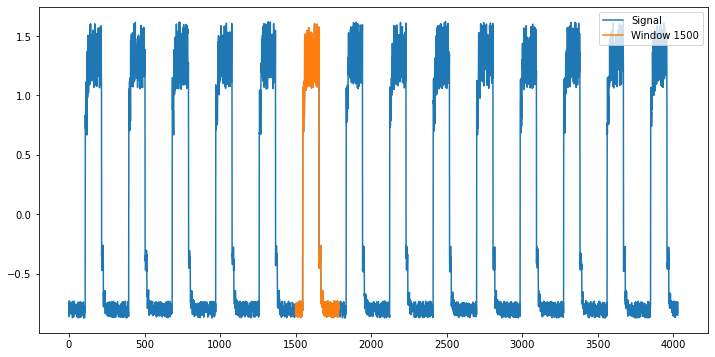

In [31]:
# note that you can change which window gets plotted - see how the orange area moves along the x-axis
window_no = 1500

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(y.shape[0]), y, label='Signal')

# set var w = window at index 200 in x_train - flatten will remove the inner arrays
w = x_train[window_no].flatten()

# plot w on top of y with label window
ax.plot(np.arange(w.shape[0]) + window_no, w, label='Window 1500')

# show the legend
ax.legend(loc="upper right");

<br>

## 3. Neural Network
***

Now that we have our training data, we need to create the neural network for our model. This section is probably the most complicated of all sections in this notebook, so I will spend some time here explaining what is happening at each stage before getting into the code.  
<br>  
We begin building our neural network by defining the layers, which are described as "_the primary building block of Keras models_" by TutotialsPoint, with each layer receiving input, performing some calculation and outputting the result to the next layer. [21] We can then optimize and compile the model.  
<br>  
The layers can be defined as follows:
##### Input  
- Here's what the [Keras documentation](https://keras.io/api/layers/core_layers/input/) tells us about the input layer:  
"_Input() is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model._"[10]  
- The input layer is literally where we input data into our model. With the input layer, we need to specify the shape of the input data we are going to use to train the model in the form of tuples [24], so in our example the input shape has sequence_length of 288 and num_features 1. [9]  

##### Conv1D  
- The next layer applied to our model is called Conv1D. According to [this GitHub post](https://kitchell.github.io/DeepLearningTutorial/4cnnsinkeras.html), the convolutional layer does the 'heavy lifting' within our neural network. In this layer, each filter (32 in our case) is slid (or convolved) along the input in strides, and as this happens an activation or feature map is produced giving the response of the filter at each position. The author goes on to explain that "_the network will learn filters that activate when they see a specific feature, such as edges if the input is an image. Each convolutional layer has multiple filters and each filter produces a separate activation or feature map. These activation maps are stacked together and passed to the next layer._" [11] In our model we are using a one dimensional Convolutional Layer, but 2D versions also exist.  
- Note that when we create the Conv1D layer, we use the argument activation="relu", which stands for rectified linear unit. In their blogpost, kitchell tells us that relu sets all negative pixels or elements of the activation to zero, which introduces non-linearity into the data to make it more like real-life data, and helps to balance out the linear convolution process. [11]  
<br>  
  
##### Dropout  
- The dropout layer is next. Jason Brownlee at machinelearningmastery.com tells us that dropout is a regularization technique for neural networks in which randomly selected neurons are ignored (or "dropped off") during training. [13] This technique is not used when evaluating the model. [13] The contribution of the dropped neurons to the activation of downstream neurons is temporally disabled on the forward pass, and any affect on the weights is not applied on the backward pass.[19]  
- Brownlee provides the following explanation on the effect of the dropout technique:  
"_As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features, providing some specialization. Neighboring neurons come to rely on this specialization, which, if taken too far, can result in a fragile model too specialized for the training data. This reliance on context for a neuron during training is referred to as complex co-adaptations.  
You can imagine that if neurons are randomly dropped out of the network during training, other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.  
The effect is that the network becomes less sensitive to the specific weights of neurons. This, in turn, results in a network capable of better generalization and less likely to overfit the training data._"[13]  
- In our model, we are using a dropout rate of 0.2. After this layer has been applied, another Conv1D layer is created, with 16 filters this time.  
<br>  

##### Conv1DTranspose  
- After the second Conv1D layer has been applied to the model, we then add a Conv1DTranspose layer. Here's what the [Keras documentation](https://keras.io/api/layers/core_layers/input/) tells us about this layer:  
"_Transposed convolution layer (sometimes called Deconvolution).The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution._"  
- This was the layer I found most difficult to understand, but based on the definition cited above and my understanding of how transpose works in Excel, I take it that in this step we are flipping the data that has been passed in the previous Conv1D step on it's head before it get's passed to the next layer.  
- Following this step, a second dropout layer is applied to the model, followed by two more Conv1DTranspose layers.  
<br>  

Once the layers have been defined, we can then create our model by passing the layers to Keras. In this example, we use a sequential model. The idea is that the layers we pass to the model are arranged in order (sequence) with the data flowing from one layer to the next until it reaches the output layer. [23]  
<br>  

The next step is optimization. The optimizer or optimization algorithm is the logic which the neural network uses to decide how much adjustment is needed on the weights on the nodes to solve the problem at hand, based on the difference between the training data and the results observed. [5] We will use an optimizer called Adam, whose name is devired from adaptive moment estimation. [5] While Adam is a form of stochastic gradient descent, it differs from the classical interpretation as the learning rate of the optimizer can adapt and do so at different rates for each weight as learning unfolds. [12]  
<br>  

With the layers, model type and optimizer defined, the last step is to choose a loss function for our model. The purpose of the loss function is to evaluate the weights and aim to minimize the error (or loss), with less error equating to a more accurate neural network. [2] The loss function we will use is called MSE (mean squared error) and is calculated as the average of the squared differences between the predicted and actual values. [14] This particular loss function punishes larger errors  more than small ones. [18]  
<br>  

We can then compile our model and take a look at it's summary information, before training the model. In training, we use x_train as both the input and the output (as we are using is a reconstruction model) [9], and set epochs, which is number of times we want the model to be evaluated during training to 50 and batch size (the number of training instances) to 128. We also pass the argument validation_split=0.1, which according to the [offical Keras documentation](https://keras.io/api/models/model_training_apis/) is a "_fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch._" [22]  
<br>  

The final argument we use in the training step is callbacks, with the class EarlyStopping, and we pass the following arguments: monitor="val_loss", patience=5, mode="min". With this argument, we are telling the model that it can stop the training when a monitored metric has stopped improving, and in this case we are telling it monitor the quantity of "val_loss", with patience (the number of epochs after which to stop the training if there is no improvement) set to 5 and mode set to min, meaning training will stop when val_loss has stopped decreasing. [7]  
<br>

Now, let's get into the code.  

<br>

In [32]:
# let's look at the shape of our training data again - we'll use this in the input layer
x_train.shape

(3745, 288, 1)

In [33]:
# defining the layers of our neural network
layers = [
  # input will be 288 (sequence length) & 1 (num_features) -> index 1 and 2 of the shape value above
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # 1st Conv1D layer with 32 filters and stride (paces to slide along data) of 2
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 1st dropout layer - ignoring/dropping off 20% of the neurons in the data
  keras.layers.Dropout(rate=0.2),
  # 2nd Conv1D layer - 16 filters this time but same stride
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 1st Conv1DTranspose layer where data is essentially flipped
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 2nd dropout layer, same rate
  keras.layers.Dropout(rate=0.2),
  # 2nd Conv1DTranspose layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 3rd Conv1DTranspose layer
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [34]:
# passing the layers to keras to create a sequential model
model = keras.Sequential(layers)

In [35]:
# using the Adam optimizer with learning rate 0.001 (this is the default learning rate)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [36]:
# compiling the module with our Adam optimizer & mean squared error loss function
model.compile(optimizer=optimizer, loss="mse")

In [37]:
# summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [38]:
# training the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 65ms/step - loss: 0.5434 - val_loss: 0.0594
Epoch 2/50
27/27 [==============================] - 1s 55ms/step - loss: 0.0784 - val_loss: 0.0426
Epoch 3/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0579 - val_loss: 0.0368
Epoch 4/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0493 - val_loss: 0.0292
Epoch 5/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0412 - val_loss: 0.0246
Epoch 6/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0356 - val_loss: 0.0220
Epoch 7/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0316 - val_loss: 0.0194
Epoch 8/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0291 - val_loss: 0.0174
Epoch 9/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0271 - val_loss: 0.0170
Epoch 10/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 11/

<br>

## 4. Evaluation
***

In this final section of code, we evaluate the performance of our model and use it to detect anomalies in our data by determining how well it can reconstruct the input data. [9]  
<br>  

We first plot the values of loss (being the loss/errors observed in the training data) against the validation loss to see how the training went. We then use our newly trained model to make predictions based on the training data and calculate the mean absolute error (MAE) loss, being the absolute difference between the predictions and actual values. [9] We will then find the maximum MAE loss value, which is the worst performance point of our model in trying to reconstruct the data and make this the threshold for anomaly detection, using the logic that "_if the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with_" (i.e. an anomaly). [9]  
<br>  

Finally, we can revisit the second dataset used in this project which contained anomalies (df_daily_jumpsup, but I will refer to it as the with-anomalies data frame) and see if the model can reconstruct those anomalies.  
<br>  


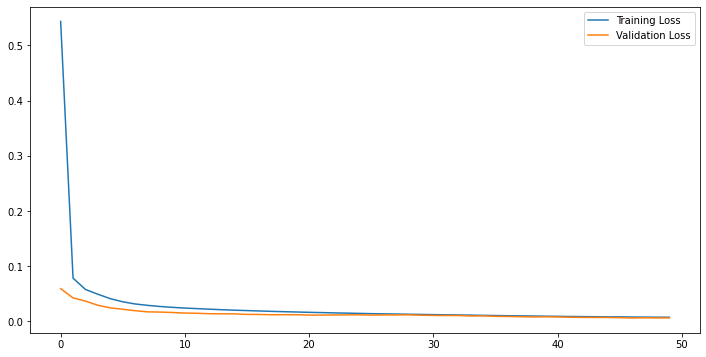

In [39]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# plotting (training) loss
ax.plot(history.history["loss"], label="Training Loss")
# plotting validation loss
ax.plot(history.history["val_loss"], label="Validation Loss")

# show the legend
ax.legend();

What the chart above tells us is that as the model completed each epoch, the values for both training loss and val_loss decreased (meaning the errors reduced) and the two values became more and more alike, which would indicate that the training was successful.  
<br>  


In [40]:
# now let's use the model to make predictions
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 6ms/step


In [41]:
# Calculate MAE loss as absolute value of the predictions minus the training values
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

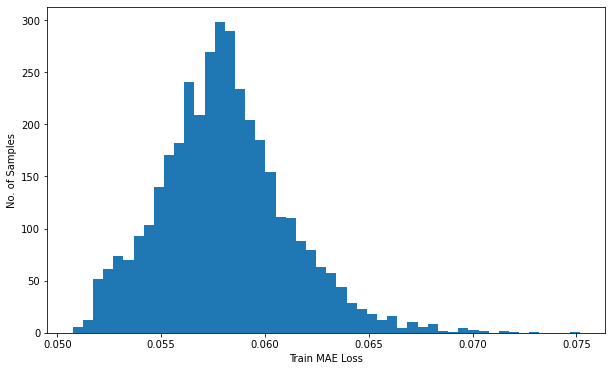

In [42]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(10, 6))

# plot MAE loss values
ax.hist(train_mae_loss, bins=50)

# setting label on x axis
ax.set_xlabel("Train MAE Loss")
# setting label on y axis
ax.set_ylabel("No. of Samples");

In [43]:
# use max MAE value as reconstruction loss threshold
threshold = np.max(train_mae_loss)

# have a look at the threshold
threshold

0.07517127897945836

In [44]:
# I wanted to take a look at the values before plotting them to make sense of the below plot

#len(x_train[0])
#x_train[0]
#len(x_train_pred[0])
#x_train_pred[0]

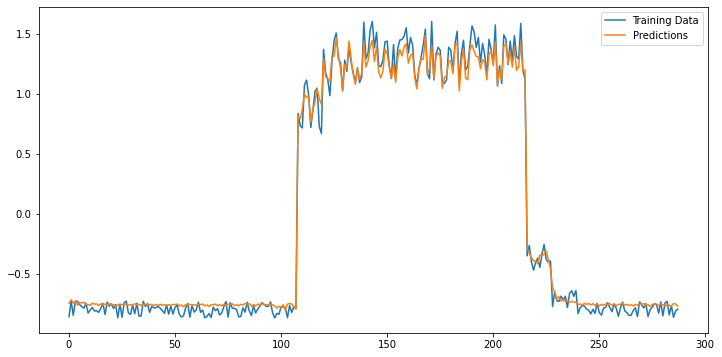

In [45]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# plotting first window of the training data (288 values)
ax.plot(x_train[0], label="Training Data")

# plotting first window of the predictions
ax.plot(x_train_pred[0], label="Predictions");

# show the legend
ax.legend();

We can see that the model was able to make predictions that were quite close to the training data, and did actually overlap with the training data values in places.  
<br>  

Now let's go back to the second dataset we imported at the beginning of this notebook which contained anomalies and plot those values.  
<br>  


In [46]:
# scaling the values in the with-anomalies dataset down, as we did with the no-anomaly data earlier
# store values in a new data frame called test_value
df_test_value = (df_daily_jumpsup - train_mean) / train_std

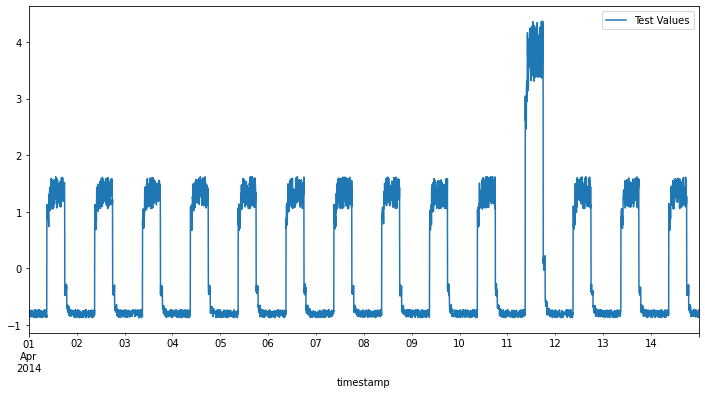

In [47]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# plot the test values in the with-anomalies dataset
df_test_value.plot(ax=ax)

plt.legend(['Test Values'], loc="upper right")

From looking at the above chart, we can see that there is a point at which the data seems to "jump up" (hence the name we gave to the data frame) somewhere between timestamps 11 and 12, but with a larger data set or one that has less variation between values, this would not be as obvious to us.
<br>  

We know that the model can't just look at a chart like we can and see if anything stands out, so what we want to see now is if the model can identify the anomalies in the data based on the training we have implemented.  
<br>  


In [48]:
# Create sequences (windows) from the test values by passing them to the windows function
x_test = windows(df_test_value.values)

# check the shape - it should be the same as the shape of the no-anomalies data
x_test.shape

(3745, 288, 1)

In [49]:
# tell the model to make predictions based on the new test windows
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 7ms/step


In [50]:
# Calculate MAE test loss as absolute value of the test predictions minus the test values
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

#test_mae_loss

In [51]:
# reshaping into a 1D array - https://www.codingem.com/numpy-reshape-minus-one/
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.05560605, 0.05922292, 0.05658624, ..., 0.05832667, 0.05878701,
       0.05856727])

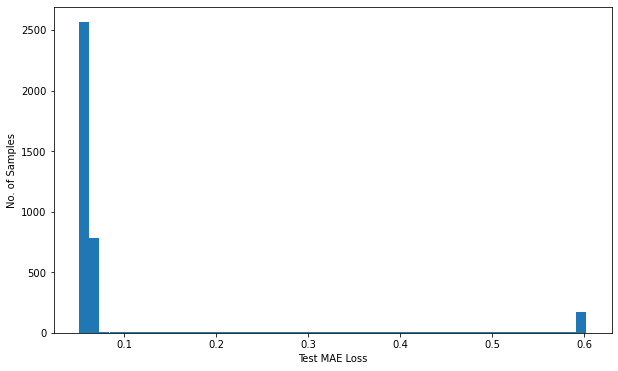

In [52]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(10, 6))

# plot the test MAE loss values
ax.hist(test_mae_loss, bins=50)

# set label on x axis
ax.set_xlabel("Test MAE Loss")

# set label on y axis
ax.set_ylabel("No. of Samples");

This plot looks quite different to the histrogram we plotted earlier using the training MAE loss values. We know now that something is off or different in the data, as the rate of MAE loss seems to soar at a particular point compared to the more normal-distribution-looking chart we saw previously.  
<br>  

Now we want to capture those anomalies.  

In [53]:
# Detect all the samples which are anomalies based on the threshold set previously
anomalies = test_mae_loss > threshold

# Number of anomalies
np.sum(anomalies)

396

In [54]:
# tested the values used in the next cell out to help me understand what was happening

# window_size -1
# = 287

# len(df_test_value)
# = 4032

# len(df_test_value) - window_size + 1
# = 3745

In [55]:
# creating a list to store the indices of the anomalies
anomaly_indices = []

# logic of function below: index i is an anomaly if samples (i - timesteps + 1) to (i) are anomalies 
# i.e. if all elements in the window are above the threshold

# loop through test values from range 287 to 3745
for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    # if all values are present (true) in the corresponding anomalies windows, append them to anomaly_indices list
    # https://www.sharpsightlabs.com/blog/numpy-all/
    if np.all(anomalies[i - window_size + 1 : i]):
        anomaly_indices.append(i)
        # I had a look at those indices - commenting out as it's quite long!
        #print (anomalies[i - window_size + 1 : i])

In [56]:
# use iloc on the with-anomalies data frame to isolate the anomaly indices in a new subset data frame
df_subset = df_daily_jumpsup.iloc[anomaly_indices]

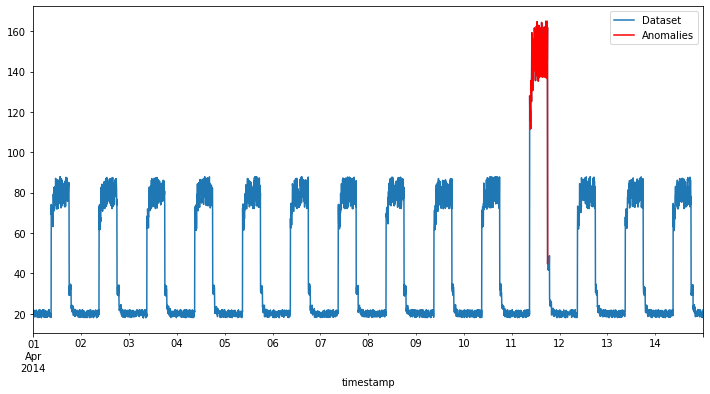

In [57]:
# create a subplot and set the figsize
fig, ax = plt.subplots(figsize=(12, 6))

# plot the values in the with-anomalies data frame
df_daily_jumpsup.plot(ax=ax)

# overlay the anomalies on top of the plot in red
df_subset.plot(ax=ax, color="r")

# show the legend - https://www.statology.org/pandas-plot-legend/
plt.legend(['Dataset', 'Anomalies']);

The area in red above is the anomalous data identified by the model, and we know that this is correct as we can see for ourselves that there is some sort of spike occurring in the data.  

<br>

## Conclusion
***

In this notebook, I have recreated and broken down the example code for timeseries anomaly detection and explained the process from gathering and pre-processing the data to using it to build a neural network with a sequential model that was successfully trained and capable of identifying anomalies in the dataset.  
<br>  

While the example followed in this notebook was successful, I was very much aware that the data central to the project was artificial data that had an obvious peak (or anomaly) that could be clearly seen in the plots I included, and I was curious as to how a similar model would perform with real life data that may not be as straight forward to work with. 
<br>  

In terms of improving the model, I would wonder if some changes to the layers would have a positive affect. In this example we applied a dropout layer to the model at two different points, but in my research I came across the suggestion to apply a dropout layer after each alternative layer, as this has produced positive results in other test cases. [13] For myself, I also wondered why we were using a stride of 2 instead of 1 when we applied the Conv1D layers. If the idea is for the network to learn from the activation responses at each position, would it not be better to slide the filter along each input and gauge that reaction, instead of every second one? Note that I have not tested this theory, but the thought did cross my mind when I was doing my research on this particular layer.  
<br>  

The other question that came to me in implementing this project was what would have happened if we had used a different optimizer. I read that the Adam optimizer which we used is supposed to punish larger errors more so than smaller ones [18], and in the case of the data used in this project that does sound like a good fit, as we know the anomaly is so large that it is visible to the human eye in the plots we recreated. However, if we were working with real-life data and it was vital that all anomalies, and not just the larger ones were identified in a timely manner (e.g. in a health care or hospital setting), I would imagine that this particular optimizer would not be acceptable.  
<br>  

Nonetheless, in this notebook I have demonstrated how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data, and no doubt a similar process could be followed to create a similar model that could work on real life data.  

<br>

## References
***

[1] https://coolconversion.com/math/scientific-notation-to-decimal/Convert_4.1E-15_to-number    
[2] https://data-flair.training/blogs/keras-loss-functions/    
[3] https://fintelics.medium.com/everything-you-need-to-know-about-numenta-anomaly-benchmark-nab-b43ab7f014df    
[4] https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb  
[5] https://www.kaggle.com/code/residentmario/keras-optimizers    
[6] https://www.kaggle.com/datasets/boltzmannbrain/nab    
[7] https://keras.io/api/callbacks/early_stopping/    
[8] https://keras.io/api/models/model_training_apis/    
[9] https://keras.io/examples/timeseries/timeseries_anomaly_detection/    
[10] https://keras.io/api/layers/core_layers/input/    
[11] https://kitchell.github.io/DeepLearningTutorial/4cnnsinkeras.html    
[12] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/    
[13] https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/    
[14] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/    
[15] https://machinelearningmastery.com/lstm-autoencoders/    
[16] https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html    
[17] https://medium.com/towards-artificial-intelligence/autoencoder-for-anomaly-detection-using-tensorflow-keras-7fdfa9f3ad99    
[18] https://neptune.ai/blog/keras-loss-functions    
[19] https://www.projectpro.io/recipes/what-is-drop-out-rate-keras    
[20] https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9    
[21] https://www.tutorialspoint.com/keras/keras_layers.htm    
[22] https://www.tutorialspoint.com/keras/keras_model_compilation.htm    
[23] https://www.tutorialspoint.com/keras/keras_models.htm    
[24] https://wandb.ai/ayush-thakur/dl-question-bank/reports/Keras-Layer-Input-Explanation-With-Code-Samples--VmlldzoyMDIzMDU  

<br>

# End
***